# ***SWaT Dataset - Anomaly Detection***

* Clovis Lechien
* Alexandre Devaux-Rivière
* Florian Segard-Gahery
* Valentin San
* Maël Reynaud

In [1]:
from typing import Tuple, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
import re

import mlsecu.data_exploration_utils as deu

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns

%matplotlib inline

In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
!ls 'data/swat/'

22June2020_1.xlsx  22June2020_2.xlsx  29June2020_1.xlsx  29June2020_2.xlsx


In [4]:
def get_summary(df : pd.DataFrame) -> pd.DataFrame:
    df_desc = pd.DataFrame(df.describe(include='all').T)
    df_summary = pd.DataFrame({
        'dtype': df.dtypes,
        'unique':df.nunique().values,
        'missing': df.isna().sum().values,
        'duplicates': df.duplicated().sum(),
        'min': df_desc['min'].values,
        'max': df_desc['max'].values,
        'avg': df_desc['mean'].values,
        'std dev': df_desc['std'].values
    })
    return df_summary

In [5]:
def list_dir(path : str, pattern : str) -> list[str]:
    return [file for file in listdir(path) if re.search(pattern, file)]

In [6]:
def preproc_df(df : pd.DataFrame) -> pd.DataFrame:
    return df[df.columns.drop(list(df.filter(regex='Unnamed')))]

In [7]:
def concat_dfs(dfs_path : list[str]) -> pd.DataFrame:
    list_of_dfs = []
    for df_path in dfs_path:
        df = preproc_df(pd.read_excel(df_path))
        list_of_dfs.append(df)
    return pd.concat(list_of_dfs, axis=0)

In [8]:
path = 'data/swat/'

pattern = r"^.*\.xlsx$"
dfs = [path + file for file in list_dir(path, pattern)]
dfs

['data/swat/29June2020_1.xlsx',
 'data/swat/29June2020_2.xlsx',
 'data/swat/22June2020_1.xlsx',
 'data/swat/22June2020_2.xlsx']

In [9]:
df = concat_dfs(dfs)
df

,t_stamp,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,...,LS401.Alarm,PSH501.Alarm,PSL501.Alarm,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm
0,6/29/20 10:00:00,3,531.168335,0.0,1,2,1,2,2.344408,72.86593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6/29/20 10:00:01,3,530.422546,0.0,1,2,1,2,2.344408,72.86593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6/29/20 10:00:02,3,530.304749,0.0,1,2,1,2,2.344408,72.930016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6/29/20 10:00:03,3,529.402,0.0,1,2,1,2,2.344408,72.930016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6/29/20 10:00:04,3,529.5197,0.0,1,2,1,2,2.345433,73.026146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2020-06-22 09:59:55,3,695.1271,0,1,1,1,2,0.000256,17.97616,...,Inactive,Inactive,Inactive,1.0,Inactive,Inactive,Active,Inactive,Inactive,Active
3596,2020-06-22 09:59:56,3,694.9701,0,1,1,1,2,0.000256,17.97616,...,Inactive,Inactive,Inactive,1.0,Inactive,Inactive,Active,Inactive,Inactive,Active
3597,2020-06-22 09:59:57,3,694.734558,0,1,1,1,2,0.000256,17.97616,...,Inactive,Inactive,Inactive,1.0,Inactive,Inactive,Active,Inactive,Inactive,Active
3598,2020-06-22 09:59:58,3,694.8523,0,1,1,1,2,0.000256,17.97616,...,Inactive,Inactive,Inactive,1.0,Inactive,Inactive,Active,Inactive,Inactive,Active


# ***Summary of the dataset***

In [10]:
get_summary(df).style.background_gradient(cmap='viridis_r', low=0.8)

,dtype,unique,missing,duplicates,min,max,avg,std dev
t_stamp,object,32402,0,0,nan,nan,nan,nan
P1_STATE,object,4,0,0,nan,nan,nan,nan
LIT101.Pv,object,5869,0,0,nan,nan,nan,nan
FIT101.Pv,object,307,0,0,nan,nan,nan,nan
MV101.Status,object,4,0,0,nan,nan,nan,nan
P101.Status,object,3,0,0,nan,nan,nan,nan
P102.Status,object,2,0,0,nan,nan,nan,nan
P2_STATE,object,3,0,0,nan,nan,nan,nan
FIT201.Pv,object,1003,0,0,nan,nan,nan,nan
AIT201.Pv,object,1818,0,0,nan,nan,nan,nan


In [11]:
def data_exploration(df : pd.DataFrame) -> None:
    dim = deu.get_nb_of_dimensions(df)
    print(bcolors.HEADER + 'Number of dimensions:' + bcolors.ENDC, dim, '\n')
    print(bcolors.HEADER + 'Number of rows:' + bcolors.ENDC, deu.get_nb_of_rows(df), '\n')
    print(bcolors.HEADER + 'Column names:' + bcolors.ENDC, deu.get_column_names(df), '\n')
    print(bcolors.HEADER + 'Number column names:' + bcolors.ENDC, deu.get_number_column_names(df), '\n')
    print(bcolors.HEADER + 'Object column names:' + bcolors.ENDC, deu.get_object_column_names(df), '\n')

    for i in range(dim):
        col = df.columns[i]
        print(bcolors.HEADER + f'Unique values of column [{col}]:' + bcolors.ENDC, deu.get_unique_values(df, col), '\n')

In [12]:
data_exploration(df)

Number of dimensions: 84 

Number of rows: 32402 

Column names: ['t_stamp', 'P1_STATE', 'LIT101.Pv', 'FIT101.Pv', 'MV101.Status', 'P101.Status', 'P102.Status', 'P2_STATE', 'FIT201.Pv', 'AIT201.Pv', 'AIT202.Pv', 'AIT203.Pv', 'MV201.Status', 'P201.Status', 'P202.Status', 'P203.Status', 'P204.Status', 'P205.Status', 'P206.Status', 'P3_STATE', 'LIT301.Pv', 'FIT301.Pv', 'DPIT301.Pv', 'MV301.Status', 'MV302.Status', 'MV303.Status', 'MV304.Status', 'P301.Status', 'P302.Status', 'P4_STATE', 'LIT401.Pv', 'FIT401.Pv', 'AIT401.Pv', 'AIT402.Pv', 'P401.Status', 'P402.Status', 'P403.Status', 'P404.Status', 'UV401.Status', 'P5_STATE', 'FIT501.Pv', 'FIT502.Pv', 'FIT503.Pv', 'FIT504.Pv', 'AIT501.Pv', 'AIT502.Pv', 'AIT503.Pv', 'AIT504.Pv', 'PIT501.Pv', 'PIT502.Pv', 'PIT503.Pv', 'P501.Status', 'P502.Status', 'MV501.Status', 'MV502.Status', 'MV503.Status', 'MV504.Status', 'P6_STATE', 'FIT601.Pv', 'P601.Status', 'P602.Status', 'd_stamp', 't_stamp.1', 'P207.Status', 'P208.Status', 'LS201.Alarm', 'LS202.Ala

# ***SWaT System Overview***

* P1: Raw Water Storage - Model-Based Monitoring System
    * MV101
    * FIT101
    * LIT101
    * T101
    * P101
    * P102
* P2: Chemical Dosing - Data-Driven / Model-Based Monitoring System
    * FIT201
    * AIT201
    * AIT202
    * AIT203
    * MV201
    * P201
    * P202
    * P203
    * P204
    * P205
    * P206
    * LS201
    * LS202
    * LSL203
    * LSLL203
* P3: Ultra-filtration (UF) - Model-Based Monitoring System
    * LIT301
    * FIT301
    * DPIT301
    * MV301
    * MV302
    * MV304
    * P301
    * P302
    * PSH301
    * DPSH301
* P4: Dechlorination - Model-Based Monitoring System
    * LIT401
    * FIT401
    * AIT401
    * AIT402
    * P401
    * P402
    * P403
    * P404
    * UV401
    * LS401
* P5: Reverse Osmosis (RO) - Data-Driven Monitoring System
    * FIT501
    * FIT502
    * FIT503
    * FIT504
    * AIT501
    * AIT502
    * AIT503
    * AIT504
    * PIT501
    * PIT502
    * PIT503
    * P501
    * P502
    * MV501
    * MV502
    * MV503
    * MV504
    * PSH501
    * PSL501
* P6: RO Permeate transfer, UF backwash - Data-Driven Monitoring System
    * FIT601
    * P601
    * P602
    * LSH601
    * LSL601
    * LSH602
    * LSL602
    * LSH603
    * LSL603

In [13]:
stamps = df.filter(regex='.*stamp.*').copy()
p1 = df.filter(regex='P1.*|.*10.*').copy()
p2 = df.filter(regex='P2.*|.*20.*').copy()
p3 = df.filter(regex='P3.*|.*30.*').copy()
p4 = df.filter(regex='P4.*|.*40.*').copy()
p5 = df.filter(regex='P5.*|.*50.*').copy()
p6 = df.filter(regex='P6.*|.*60.*').copy()

In [14]:
def check_sum_columns(ref: pd.DataFrame, list_df : list[pd.DataFrame]) -> bool | None:
    if ref is None or list_df is None:
        return None
    cumsum = 0
    for df_ in list_df:
        cumsum += deu.get_nb_of_dimensions(df_)
    return cumsum == deu.get_nb_of_dimensions(ref)

check_sum_columns(df, [stamps, p1, p2, p3, p4, p5, p6])

True

In [65]:
# Utils

def prepare_dfs(list_df : list[pd.DataFrame]) -> pd.DataFrame:
    df = pd.concat(list_df, axis=1).copy()
    df = df.apply(pd.to_numeric, errors='coerce')
    df.fillna(value=0, inplace=True)
    return df


def scale_data(df : pd.DataFrame) -> np.ndarray:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    print(f'Scaled data shape: {scaled_data.shape}')

    return scaled_data


def pca_(scaled_data : np.ndarray, var_retention : float = 0.95) -> tuple[Any, Any]:
    pca = PCA(n_components=var_retention)
    pca_components = pca.fit_transform(scaled_data)

    print(f'PCA Components: {pca_components.shape}')

    return pca_components, pca


def metrics_pca(pca : Any, scaled_data : np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    reconstructed = pca.inverse_transform(pca_components)
    reconstruction_error = np.mean((scaled_data - reconstructed) ** 2, axis=1)

    plt.plot(reconstruction_error)

    threshold_pca = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)
    anomalies_pca = reconstruction_error > threshold_pca

    print(f'Number of anomalies: {np.sum(anomalies_pca)}')

    return reconstruction_error, threshold_pca, anomalies_pca


def metrics_iso_forest(scaled_data : np.ndarray, contamination : float = 0.01, random_state : int = 42) -> tuple[np.ndarray, np.ndarray]:
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)

    anomaly_scores = iso_forest.fit_predict(scaled_data)
    anomalies_iforest = anomaly_scores == -1

    return anomaly_scores, anomalies_iforest


def metrics_lof(scaled_data : np.ndarray, contamination : float = 0.01, n_neighbors : int = 20) -> tuple[np.ndarray, np.ndarray]:
    loc_out_factor = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)

    anomaly_scores = loc_out_factor.fit_predict(scaled_data)
    anomalies_lof = anomaly_scores == -1

    return anomaly_scores, anomalies_lof


def plot_reconstruction_error():
    plt.figure(figsize=(12, 6))
    plt.plot(reconstruction_error, label='Reconstruction Error', color='blue')
    plt.axhline(threshold_pca, color='red', linestyle='--', label='Anomaly Threshold')
    plt.title('Reconstruction Error with Anomaly Threshold')
    plt.xlabel('Time Index')
    plt.ylabel('Error')
    plt.legend()
    plt.show()


def plot_heatmap():
    plt.figure(figsize=(15, 8))
    data = p1_6[p1_6['Anomaly'] == True].iloc[:, :-3].apply(pd.to_numeric, errors='coerce').fillna(0)
    data = data.select_dtypes(include=[np.number])
    sns.heatmap(data.T, cmap='coolwarm', cbar=True)
    plt.title('Heatmap of Sensors During Anomalies')
    plt.xlabel('Time Index')
    plt.ylabel('Sensors')
    plt.show()


def check_common_anomalies(anomalies_pca: np.ndarray, anomalies_iforest: np.ndarray, anomalies_lof: np.ndarray) -> None:
    common_anomalies_all = anomalies_pca & anomalies_iforest & anomalies_lof
    common_anomalies_pca_iforest = anomalies_pca & anomalies_iforest
    common_anomalies_pca_lof = anomalies_pca & anomalies_lof
    common_anomalies_iforest_lof = anomalies_iforest & anomalies_lof

    print(f"Total common anomalies detected by all methods: {np.sum(common_anomalies_all)}")
    print(f"Total common anomalies detected by PCA and Isolation Forest: {np.sum(common_anomalies_pca_iforest)}")
    print(f"Total common anomalies detected by PCA and Local Outlier Factor: {np.sum(common_anomalies_pca_lof)}")
    print(f"Total common anomalies detected by Isolation Forest and Local Outlier Factor: {np.sum(common_anomalies_iforest_lof)}")

# ***Multi Stage Multi Point (MSMP)***
Targets multiple sensors at multiple points in time.

In [51]:
p1_6 = prepare_dfs([p1, p2, p3, p4, p5, p6])
p1_6

,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,AIT202.Pv,...,FIT601.Pv,P601.Status,P602.Status,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm
0,3.0,531.168335,0.0,1.0,2.0,1.0,2.0,2.344408,72.865930,8.722956,...,0.000256,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,530.422546,0.0,1.0,2.0,1.0,2.0,2.344408,72.865930,8.722956,...,0.000256,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,530.304749,0.0,1.0,2.0,1.0,2.0,2.344408,72.930016,8.722956,...,0.000256,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,529.402000,0.0,1.0,2.0,1.0,2.0,2.344408,72.930016,8.722956,...,0.000256,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,529.519700,0.0,1.0,2.0,1.0,2.0,2.345433,73.026146,8.722956,...,0.000256,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3.0,695.127100,0.0,1.0,1.0,1.0,2.0,0.000256,17.976160,7.543130,...,0.000256,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3596,3.0,694.970100,0.0,1.0,1.0,1.0,2.0,0.000256,17.976160,7.543130,...,0.000256,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3597,3.0,694.734558,0.0,1.0,1.0,1.0,2.0,0.000256,17.976160,7.539285,...,0.000256,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3598,3.0,694.852300,0.0,1.0,1.0,1.0,2.0,0.000256,17.976160,7.530954,...,0.000256,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
scaled_data = scale_data(p1_6)

Scaled data shape: (32402, 81)


## ***PCA***

In [53]:
pca_components, pca = pca_(scaled_data)

PCA Components: (32402, 17)


Number of anomalies: 380


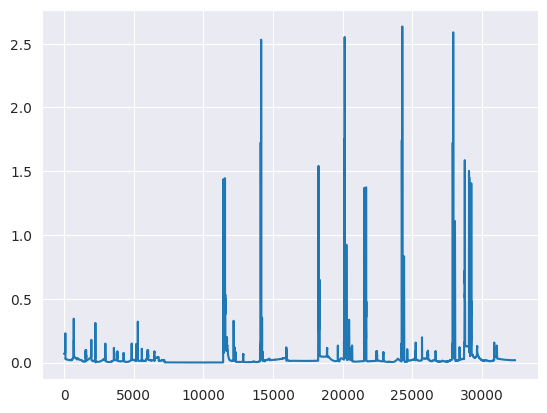

In [54]:
reconstruction_error, threshold_pca, anomalies_pca  = metrics_pca(pca, scaled_data)

## ***Isolation Forest***

In [55]:
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

## ***Local Outlier Factor***

In [56]:
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

## ***Combining Anomalies***

In [57]:
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof

In [58]:
p1_6['Anomaly'] = combined_anomalies
p1_6['Reconstruction_Error'] = reconstruction_error
p1_6['Isolation_Score'] = anomaly_scores_iso
p1_6['Lof_Score'] = anomaly_scores_lof

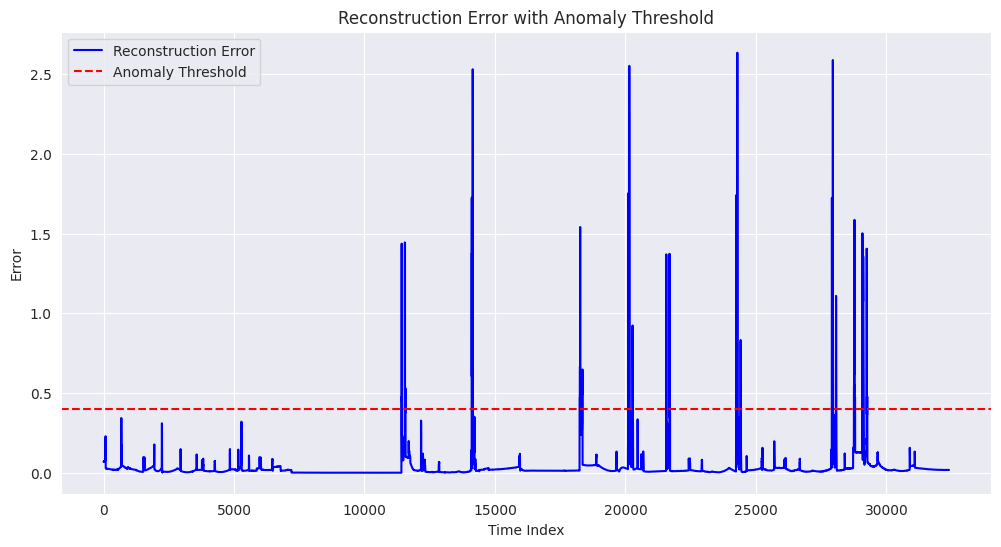

In [59]:
plot_reconstruction_error()

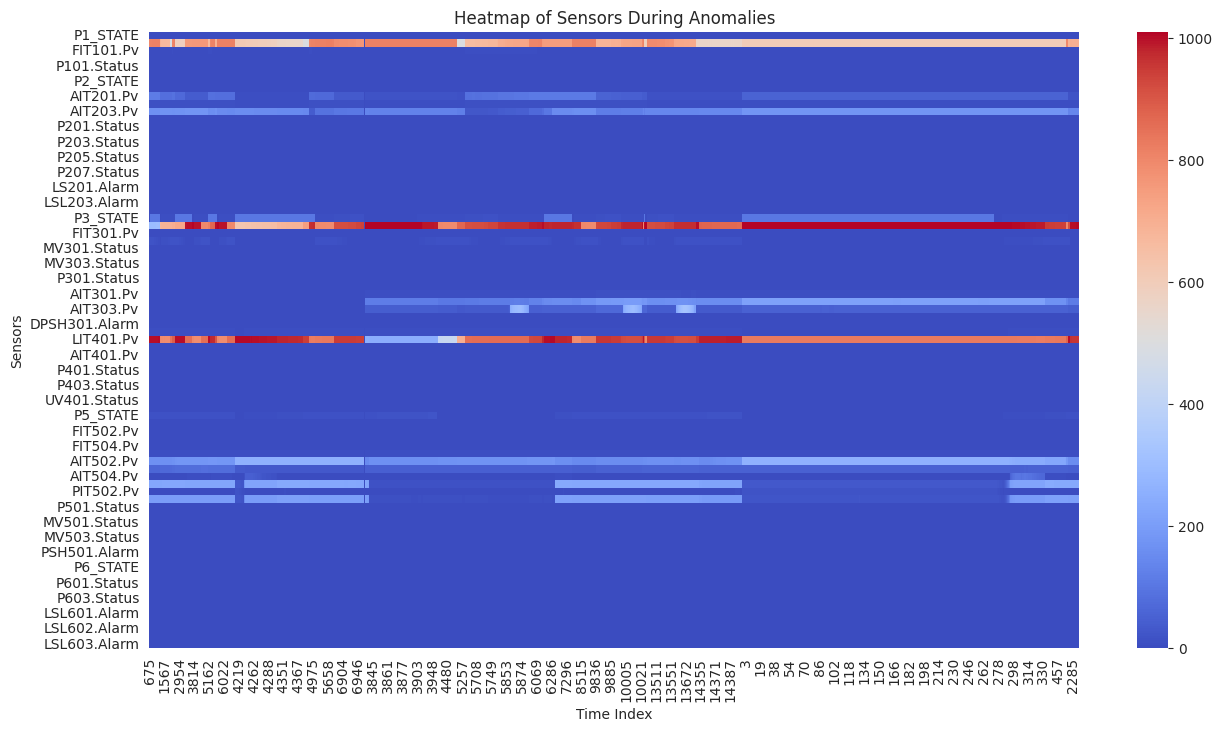

In [60]:
plot_heatmap()

In [67]:
print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies(anomalies_pca, anomalies_iforest, anomalies_lof)

Total anomalies detected by PCA: 380
Total anomalies detected by Isolation Forest: 325
Total anomalies detected by Local Outlier Factor: 325


Total common anomalies detected by all methods: 0
Total common anomalies detected by PCA and Isolation Forest: 11
Total common anomalies detected by PCA and Local Outlier Factor: 19
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 1


## ***Single Stage Multi Point (SSMP)***
Targets multiple sensors at a single point in time.

In [ ]:
# meme chose mais on va faire sur p1 - p6 independamment des autres.

# ***Attack types***

Total number of attacks: 36.

-> ça vient du papier..

## ***Single Stage Single Point (SSSP)***
Targets a single sensor at a single point in time.

In [ ]:
# TODO

## ***Multi Stage Single Point (MSSP)***
Targets a single sensor at multiple points in time.

In [ ]:
# TODO